In [1]:
#!pip install python-dotenv pymongo elasticsearch matplotlib SPARQLWrapper sentence_transformers

In [2]:
from dotenv import dotenv_values
import pymongo
from elasticsearch import Elasticsearch
import matplotlib.pyplot as plt
import random
from datetime import datetime, timedelta
import time
from SPARQLWrapper import SPARQLWrapper, POST, JSON, CSV
from dateutil.relativedelta import relativedelta
from sentence_transformers import SentenceTransformer
import os
import subprocess
import pprint

# Configuracion entorno

In [3]:
env_config = dotenv_values("../.env")

In [4]:
mongo_client = pymongo.MongoClient(
    host=env_config['MONGODB_HOST'],
    port=int(env_config['MONGODB_PORT']),
    username=env_config['MONGO_USER'],
    password=env_config['MONGO_PASSWORD'],
)
mongo_collection = mongo_client["boe_db"]["boe"]

In [5]:
es_client = Elasticsearch(f"http://{env_config['ELASTICSEARCH_HOST']}:{env_config['ELASTICSEARCH_PORT']}")
model = SentenceTransformer(env_config["SENTENCE_TRANSFORMER_MODEL"])

In [6]:
sparql = SPARQLWrapper(
    f"http://{env_config['GRAPHDB_HOST']}:{env_config['GRAPHDB_PORT']}"
    f"/repositories/{env_config['GRAPHDB_REPOSITORY']}"
)
sparql.setMethod(POST)

# Pruebas de rendimiento

## Aux funcs

In [7]:
def load_data(start_date, end_date):
    current_start_date_str = start_date.strftime('%Y-%m-%d')
    current_end_date_str = end_date.strftime('%Y-%m-%d')

    print(f"Fecha inicio: {current_start_date_str}")
    print(f"Fecha fin: {current_end_date_str}")
    print("Cargando datos en mongo")
    os.popen(f"python3 ../scripts/load_mongodb.py --env-file ../.env --path ../downloads dates -s {current_start_date_str} -e {current_end_date_str}").read()
    print("Cargando datos en elastic")
    #os.popen(f"python3 ../scripts/load_elasticsearch.py --env-file ../.env -c 20 dates -s {current_start_date_str} -e {current_end_date_str}").read()
    print("Cargando datos en graphdb")
    os.popen(f"python3 ../scripts/load_graphdb.py --env-file ../.env dates -s {current_start_date_str} -e {current_end_date_str}").read()
    

In [8]:
def batch_timing_mongo(batch_querys):
    
    timer_start = time.time()
    for query in batch_querys:
        mongo_collection.find(query)
    timer_end = time.time()

    elapsed_time = timer_end - timer_start
    print(f"Tiempo de ejecución para {len(batch_querys)} querys: {elapsed_time:.5f}")
    return elapsed_time


In [9]:
def batch_timing_graph(batch_querys):
    
    timer_start = time.time()
    for query in batch_querys:
        sparql.setReturnFormat(JSON)
        sparql.setQuery(query)
        results = sparql.query().convert()
    timer_end = time.time()

    elapsed_time = timer_end - timer_start
    print(f"Tiempo de ejecución para {len(batch_querys)} querys: {elapsed_time:.5f}")
    return elapsed_time

## Tamaño BD variable

In [10]:
n_repeticiones = 1000
start_date_data = datetime.strptime('2023-01-01', '%Y-%m-%d')
one_month = relativedelta(months=1)

### Limpieza de datos previos y configuración BDs

In [11]:
# clean mongo
mongo_collection.delete_many({})
mongo_collection.drop()
# clean elastic
try:
    es_client.indices.delete(index="boe")
except:
    pass
# clean graphdb
query = """
DELETE { ?s ?p ?o }
WHERE { ?s ?p ?o }
"""
sparql.setReturnFormat(JSON)
sparql.setQuery(query)
try:
    results = sparql.query().convert()
except Exception as e:
    print('Error al limpiar graphdb') #No funciona desde python, se debe hacer manualmente
    print(e)

Error al limpiar graphdb
QueryBadFormed: A bad request has been sent to the endpoint: probably the SPARQL query is badly formed. 

Response:
b'Missing parameter: query'


In [12]:
print(os.popen("python3 ../scripts/setup_dbs.py --env-file ../.env --graphdb-repo-init-file ../rdf/graphdb_init.ttl --graphdb-init-query ../rdf/graphdb_init_query.txt").read())
time.sleep(10)

Setting up MongoDB...
Done!
Setting up Elasticsearch...
Index does not exist. Creating...
Done!
Setting up GraphDB...
{"message":"Repository boe already exists."}
{'vary': 'Accept-Encoding', 'cache-control': 'no-store', 'content-language': 'en-US', 'date': 'Tue, 14 Nov 2023 21:27:45 GMT', 'connection': 'close', 'server': 'GraphDB/10.4.1 RDF4J/4.3.6'}



In [13]:
#check number of documents in mongo
print(f"Number of documents in mongo: {mongo_collection.count_documents({})}")
#check number of documents in elastic
print(f"Number of documents in elastic: {es_client.count(index='boe')['count']}")
#check number of triples in graphdb
query_count_triples = """
    SELECT (COUNT(*) as ?count)
    WHERE { ?s ?p ?o }
"""
sparql.setQuery(query_count_triples)
sparql.setReturnFormat(JSON)
results = sparql.query().convert()
print(f"Number of triples in graphdb: {results['results']['bindings'][0]['count']['value']}")

Number of documents in mongo: 0
Number of documents in elastic: 0
Number of triples in graphdb: 177


### MongoDB

#### Por fecha

In [14]:
def mongo_by_date(end_date):
    batch_querys = []
    for i in range(n_repeticiones):
        start_date = start_date_data + timedelta(days=int(random.random() * (end_date - start_date_data).days))
        end_date = start_date + timedelta(days=1)
        query_fecha = {
                    "fecha_publicacion": {
                        "$gte": start_date,
                        "$lte": end_date,
                    }
                }
        batch_querys.append(query_fecha)
    return batch_timing_mongo(batch_querys)/n_repeticiones

#### Por indentificador

In [15]:
def mongo_by_id():
    batch_querys = []
    identificadores = mongo_collection.distinct('identificador')
    for i in range(n_repeticiones):
        query_identificador = {
                    "identificador": random.choice(identificadores)
                }
        batch_querys.append(query_identificador)
    return batch_timing_mongo(batch_querys)/n_repeticiones

#### Por materia

In [16]:
def mongo_by_materia():
    batch_querys = []
    codigos = mongo_collection.distinct('materias.codigo')
    for i in range(n_repeticiones):
        query_codigo = {
                    "materias.codigo": random.choice(codigos)
                }
        batch_querys.append(query_codigo)
    return batch_timing_mongo(batch_querys)/n_repeticiones

### GraphDB

In [17]:
PREFIXES = """
PREFIX  :     <http://www.semanticweb.org/hackathon/ontology/>
PREFIX  owl:  <http://www.w3.org/2002/07/owl#>
PREFIX  rdf:  <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX  xml:  <http://www.w3.org/XML/1998/namespace>
PREFIX  xsd:  <http://www.w3.org/2001/XMLSchema#>
PREFIX  rdfs: <http://www.w3.org/2000/01/rdf-schema#>
"""

#### Por fecha

In [18]:
def encode_date(date):
    return f'"{date.strftime("%Y-%m-%d")}"^^xsd:date'

In [19]:
def graph_by_date(end_date):
    batch_querys = []
    for i in range(n_repeticiones):
        date = start_date_data + timedelta(days=int(random.random() * (end_date - start_date_data).days))
        query_fecha = PREFIXES + f"""SELECT ?entradaBOE
                                WHERE {{
                                    ?entradaBOE rdf:type :EntradaBOE .
                                    ?entradaBOE :fechaPublicacion {encode_date(date)} .
                                }}
                                """  
        batch_querys.append(query_fecha)
    return batch_timing_graph(batch_querys)/n_repeticiones

#### Por indentificador

In [20]:
def graph_by_id():
    batch_querys = []
    identificadores = mongo_collection.distinct('identificador')
    for i in range(n_repeticiones):
        query_identificador = PREFIXES + f"""SELECT ?entradaBOE
                                WHERE {{
                                    ?entradaBOE rdf:type :EntradaBOE .
                                    ?entradaBOE :identificador "{random.choice(identificadores)}" .
                                }}
                                """     
        batch_querys.append(query_identificador)
    return batch_timing_graph(batch_querys)/n_repeticiones

### Lanzamiento de pruebas

In [21]:
times_mongo = {}
times_graph = {}
for i in range(12):
    times_mongo_tipos = {}
    times_graph_tipos = {}

    current_start_date = start_date_data + one_month * i
    current_end_date = start_date_data + one_month * (i + 1)
    
    load_data(current_start_date, current_end_date)
    
    n_docs = mongo_collection.count_documents({})
    sparql.setQuery(query_count_triples)
    sparql.setReturnFormat(JSON)
    results = sparql.query().convert()
    n_triples = results['results']['bindings'][0]['count']['value']

    print(f"Number of documents in mongo: {n_docs}")
    print(f"Number of documents in elastic: {es_client.count(index='boe')['count']}")
    print(f"Number of triples in graphdb: {n_triples}")
    
    print('Fecha:')
    times_mongo_tipos['date'] = mongo_by_date(current_end_date)
    times_graph_tipos['date'] = graph_by_date(current_end_date)
    print('Identificador:')
    times_mongo_tipos['id'] = mongo_by_id()
    times_graph_tipos['id'] = graph_by_id()
    print('Materia:')
    times_mongo_tipos['materia'] = mongo_by_materia()
    
    times_mongo[n_docs] = times_mongo_tipos
    times_graph[n_triples] = times_graph_tipos

    print('\n')
    print(30*'=')

Fecha inicio: 2023-01-01
Fecha fin: 2023-02-01
Cargando datos en mongo
Cargando datos en elastic
Cargando datos en graphdb
Number of documents in mongo: 5966
Number of documents in elastic: 0
Number of triples in graphdb: 46958
Fecha:
Tiempo de ejecución para 1000 querys: 0.00466
Tiempo de ejecución para 1000 querys: 3.21344
Identificador:
Tiempo de ejecución para 1000 querys: 0.00433
Tiempo de ejecución para 1000 querys: 2.37431
Materia:
Tiempo de ejecución para 1000 querys: 0.00421


Fecha inicio: 2023-02-01
Fecha fin: 2023-03-01
Cargando datos en mongo
Cargando datos en elastic
Cargando datos en graphdb
Number of documents in mongo: 11585
Number of documents in elastic: 0
Number of triples in graphdb: 88873
Fecha:
Tiempo de ejecución para 1000 querys: 0.00427
Tiempo de ejecución para 1000 querys: 3.25067
Identificador:
Tiempo de ejecución para 1000 querys: 0.00398
Tiempo de ejecución para 1000 querys: 2.37803
Materia:
Tiempo de ejecución para 1000 querys: 0.00437


Fecha inicio: 202

In [22]:
pprint.pprint(times_mongo)

{5966: {'date': 4.657268524169922e-06,
        'id': 4.325628280639649e-06,
        'materia': 4.213094711303711e-06},
 11585: {'date': 4.266262054443359e-06,
         'id': 3.9844512939453124e-06,
         'materia': 4.374027252197266e-06},
 18086: {'date': 4.055976867675781e-06,
         'id': 3.992557525634765e-06,
         'materia': 3.6237239837646484e-06},
 23363: {'date': 4.331827163696289e-06,
         'id': 3.998517990112305e-06,
         'materia': 4.029989242553711e-06},
 29524: {'date': 4.362344741821289e-06,
         'id': 4.041910171508789e-06,
         'materia': 4.332542419433594e-06},
 35583: {'date': 4.520893096923828e-06,
         'id': 4.065275192260742e-06,
         'materia': 4.225969314575196e-06},
 40724: {'date': 4.308700561523437e-06,
         'id': 4.039525985717774e-06,
         'materia': 4.306554794311523e-06},
 43714: {'date': 4.650354385375976e-06,
         'id': 4.261255264282227e-06,
         'materia': 4.087448120117187e-06},
 48631: {'date': 4.386425

In [23]:
pprint.pprint(times_graph)

{'136254': {'date': 0.003254676580429077, 'id': 0.0023470845222473146},
 '173725': {'date': 0.003276076078414917, 'id': 0.002353510618209839},
 '216629': {'date': 0.003169771909713745, 'id': 0.002429383993148804},
 '258157': {'date': 0.003306825876235962, 'id': 0.002345750570297241},
 '294845': {'date': 0.0031891849040985108, 'id': 0.0023551411628723144},
 '315094': {'date': 0.003153438329696655, 'id': 0.002350390672683716},
 '347463': {'date': 0.0032040112018585204, 'id': 0.0023144018650054932},
 '385175': {'date': 0.003156207323074341, 'id': 0.002358051300048828},
 '398145': {'date': 0.0030183961391448974, 'id': 0.002386073350906372},
 '46958': {'date': 0.0032134382724761964, 'id': 0.002374314785003662},
 '88873': {'date': 0.003250674486160278, 'id': 0.002378026485443115}}


#### Plot de resultados

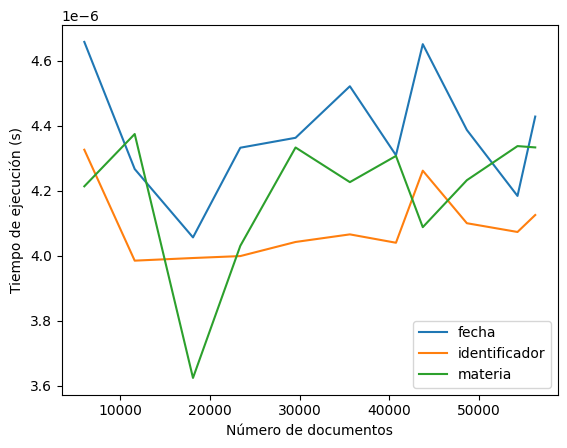

In [24]:
x = list(times_mongo.keys())
y = {k: [v['date'], v['id'], v['materia']] for k, v in times_mongo.items()}
y = list(y.values())
plt.plot(x, y)
plt.legend(['fecha', 'identificador', 'materia'])
plt.xlabel('Número de documentos')
plt.ylabel('Tiempo de ejecución (s)')
plt.show()

## Tamaño BD fijo

In [25]:
n_querys_mongo = [1000, 5000, 10000, 50000, 100000, 500000, 1000000]
n_querys_graph = [100, 500, 1000, 5000, 10000]

### MongoDB

In [26]:
times_mongo = {}

#### Por fecha

In [27]:
times_dates = {}
start_date_data = datetime.strptime('2023-01-01', '%Y-%m-%d')

for n in n_querys_mongo:
    batch_querys = []
    for i in range(n):
        start_date = start_date_data + timedelta(days=int(random.random() * 365))
        end_date = start_date + timedelta(days=1)
        query_fecha = {
                    "fecha_publicacion": {
                        "$gte": start_date,
                        "$lte": end_date,
                    }
                }
        batch_querys.append(query_fecha)
    times_dates[n] = batch_timing_mongo(batch_querys)

times_mongo['fecha'] = times_dates

Tiempo de ejecución para 1000 querys: 0.00430
Tiempo de ejecución para 5000 querys: 0.02301
Tiempo de ejecución para 10000 querys: 0.04355
Tiempo de ejecución para 50000 querys: 0.21323
Tiempo de ejecución para 100000 querys: 0.41409
Tiempo de ejecución para 500000 querys: 2.07643
Tiempo de ejecución para 1000000 querys: 3.81489


#### Por indentificador

In [28]:
identificadores = mongo_collection.distinct('identificador')
times_identificadores = {}
for n in n_querys_mongo:
    batch_querys = []
    for i in range(n):
        query_identificador = {
                    "identificador": random.choice(identificadores)
                }
        batch_querys.append(query_identificador)
    times_identificadores[n] = batch_timing_mongo(batch_querys)
times_mongo['identificador'] = times_identificadores

Tiempo de ejecución para 1000 querys: 0.00370
Tiempo de ejecución para 5000 querys: 0.02078
Tiempo de ejecución para 10000 querys: 0.04308
Tiempo de ejecución para 50000 querys: 0.20616
Tiempo de ejecución para 100000 querys: 0.41965
Tiempo de ejecución para 500000 querys: 2.06467
Tiempo de ejecución para 1000000 querys: 4.16754


#### Por materia

In [29]:
codigos = mongo_collection.distinct('materias.codigo')

for n in n_querys_mongo:
    batch_querys = []
    for i in range(n):
        query_codigo = {
                    "materias.codigo": random.choice(codigos)
                }
        batch_querys.append(query_codigo)
    times_identificadores[n] = batch_timing_mongo(batch_querys)
times_mongo['codigo'] = times_identificadores

Tiempo de ejecución para 1000 querys: 0.00438
Tiempo de ejecución para 5000 querys: 0.02099
Tiempo de ejecución para 10000 querys: 0.04197
Tiempo de ejecución para 50000 querys: 0.21725
Tiempo de ejecución para 100000 querys: 0.39649
Tiempo de ejecución para 500000 querys: 1.86215
Tiempo de ejecución para 1000000 querys: 4.17828


#### Plot de resultados

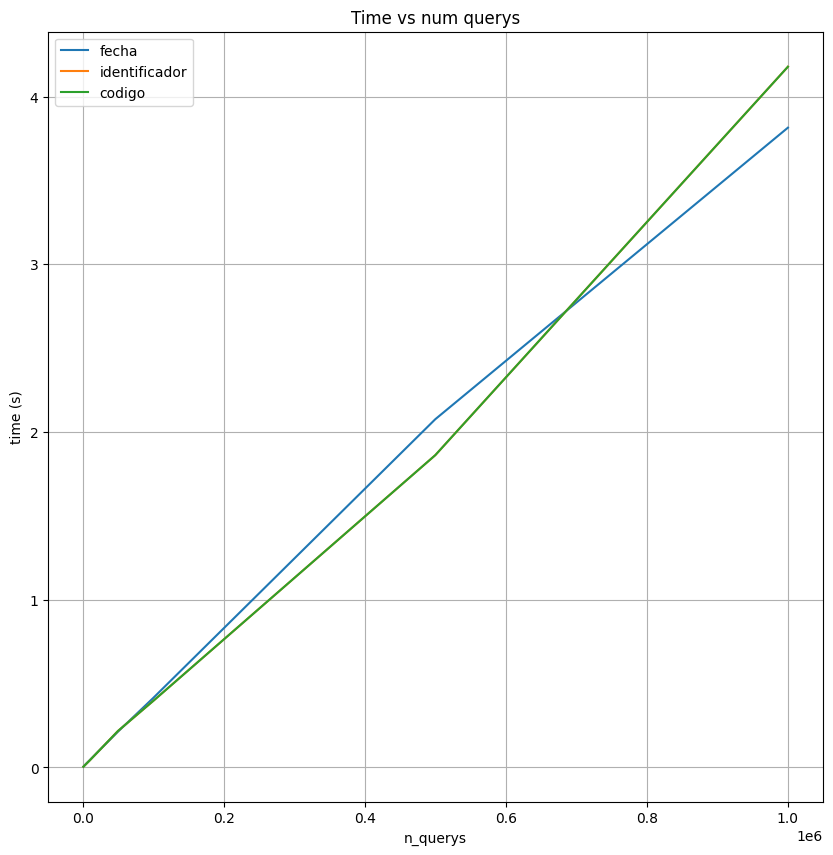

In [30]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 10)
for query_type in times_mongo:
    ax.plot(n_querys_mongo, times_mongo[query_type].values(), label=query_type)
ax.set(xlabel='n_querys', ylabel='time (s)', title='Time vs num querys')
ax.grid()
ax.legend()
plt.show()

### GraphDB

In [31]:
times_graph = {}

In [32]:
PREFIXES = """
PREFIX  :     <http://www.semanticweb.org/hackathon/ontology/>
PREFIX  owl:  <http://www.w3.org/2002/07/owl#>
PREFIX  rdf:  <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX  xml:  <http://www.w3.org/XML/1998/namespace>
PREFIX  xsd:  <http://www.w3.org/2001/XMLSchema#>
PREFIX  rdfs: <http://www.w3.org/2000/01/rdf-schema#>
"""

#### Por fecha

In [33]:
def encode_date(date):
    return f'"{date.strftime("%Y-%m-%d")}"^^xsd:date'

In [34]:
times_dates = {}
start_date_data = datetime.strptime('2023-01-01', '%Y-%m-%d')

for n in n_querys_graph:
    batch_querys = []
    for i in range(n):
        date = start_date_data + timedelta(days=int(random.random() * 365))
        query_fecha = PREFIXES + f"""SELECT ?entradaBOE
                                WHERE {{
                                    ?entradaBOE rdf:type :EntradaBOE .
                                    ?entradaBOE :fechaPublicacion {encode_date(date)} .
                                }}
                                """  
        batch_querys.append(query_fecha)
    times_dates[n] = batch_timing_graph(batch_querys)

times_graph['fecha'] = times_dates

Tiempo de ejecución para 100 querys: 0.34137
Tiempo de ejecución para 500 querys: 1.54768
Tiempo de ejecución para 1000 querys: 3.11355
Tiempo de ejecución para 5000 querys: 15.39192
Tiempo de ejecución para 10000 querys: 30.45997


#### Por indentificador

In [35]:
identificadores = mongo_collection.distinct('identificador')
times_identificadores = {}
for n in n_querys_graph:
    batch_querys = []
    for i in range(n):
        query_identificador = PREFIXES + f"""SELECT ?entradaBOE
                                WHERE {{
                                    ?entradaBOE rdf:type :EntradaBOE .
                                    ?entradaBOE :identificador "{random.choice(identificadores)}" .
                                }}
                                """     
        batch_querys.append(query_identificador)
    times_identificadores[n] = batch_timing_graph(batch_querys)
times_graph['identificador'] = times_identificadores

Tiempo de ejecución para 100 querys: 0.24710
Tiempo de ejecución para 500 querys: 1.16922
Tiempo de ejecución para 1000 querys: 2.46481
Tiempo de ejecución para 5000 querys: 12.31082
Tiempo de ejecución para 10000 querys: 24.31893


#### Plot de resultados

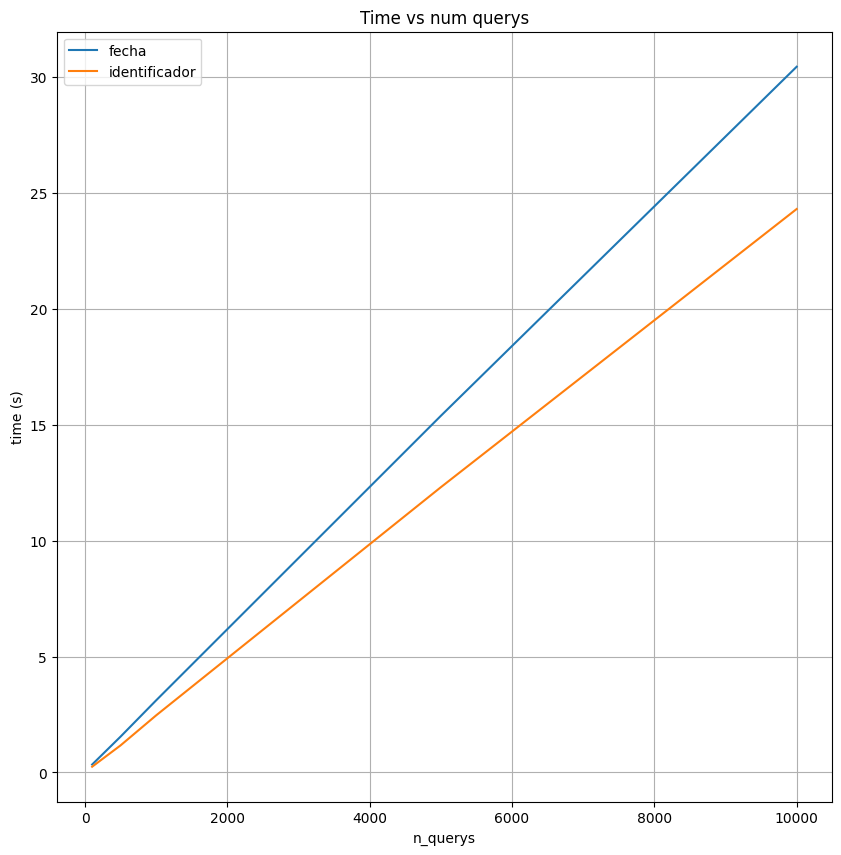

In [36]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 10)
for query_type in times_graph:
    ax.plot(n_querys_graph, times_graph[query_type].values(), label=query_type)
ax.set(xlabel='n_querys', ylabel='time (s)', title='Time vs num querys')
ax.grid()
ax.legend()
plt.show()